# Probability Models

To generate profiles, we use the [Preflib.org](https://preflib.org) tools available at [https://github.com/PrefLib/PrefLib-Tools](https://github.com/PrefLib/PrefLib-Tools).   


## Impartial (Anonymous) Culture

1. IC: Impartial Culture Model - generate a profile by sampling  from a uniform distribution over profiles with $n$ candidates and $m$ voters. 

2. IAC: Impartial Anonymous Culture Model - generate a profile by sampling  from a uniform distribution over *anonymous* profiles with $n$ candidates and $m$ voters. 

3. INAC: Impartial Anonymous and Neutral Culture Model<br/>
    O. Egecioglu and A. Giritligil (2013). [The Impartial, Anonymous, and Neutral Culture Model: A Probability Model for Sampling Public Preference Structures](https://sites.cs.ucsb.edu/~omer/DOWNLOADABLE/GMAS_public_preference13.pdf), Journal of Mathematical Sociology, 37: pp. 203 - 222

In [1]:
# import the Profile class
from voting.profiles import Profile
from voting.generate_profiles import *
from voting.voting_methods import *
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
import pickle
import random

from tqdm.notebook import tqdm

In [2]:
pm="IC"
num_trials = 1000
num_candidates = 5
num_voters = 1001

num_condorcet_winner = 0
num_cycles = 0
for t in range(num_trials): 
    prof = generate_profile(num_candidates, num_voters, probmod = pm)
    num_condorcet_winner += prof.condorcet_winner() is not None
    num_cycles += has_cycle(prof.margin_graph())
    
print(f"{round(num_condorcet_winner / num_trials, 2) *100}% of profiles have a Condorcet winner.")
print(f"{round(num_cycles / num_trials, 2) *100}% of profiles have a majority cycle.")

74.0% of profiles have a Condorcet winner.
46.0% of profiles have a majority cycle.


In [3]:
pm="IAC"
num_trials = 1000
num_candidates = 5
num_voters = 1001

num_condorcet_winner = 0
num_cycles = 0
for t in range(num_trials): 
    prof = generate_profile(num_candidates, num_voters, probmod = pm)
    num_condorcet_winner += prof.condorcet_winner() is not None
    num_cycles += has_cycle(prof.margin_graph())
print(f"{round(num_condorcet_winner / num_trials, 2) *100}% of profiles have a Condorcet winner.")
print(f"{round(num_cycles / num_trials, 2) * 100}% of profiles have a majority cycle.")

72.0% of profiles have a Condorcet winner.
48.0% of profiles have a majority cycle.


In [4]:
%%time 

SKIP_SIMULATION = True

if not SKIP_SIMULATION: 
    all_num_candidates = [3, 4, 5, 6, 10]
    all_num_voters = [10, 11, 100, 101, 1000, 1001]
    num_trials = 25000

    voting_scenarios = list(product(all_num_candidates, all_num_voters))
    data = {vs: 
            {
                "perc_condorcet_winners": {"IC": 0, "IAC": 0},
                "perc_cycles": {"IC": 0, "IAC": 0},            
            } 
            for vs in voting_scenarios
           }

    for nc, nv in tqdm(voting_scenarios): 
        num_condorcet_winner_IC = 0
        num_condorcet_winner_IAC = 0
        num_cycle_IC = 0
        num_cycle_IAC = 0
        for t in range(num_trials): 
            prof_IC = generate_profile(nc, nv, probmod="IC")       
            prof_IAC = generate_profile(nc, nv, probmod="IAC")        

            num_condorcet_winner_IC += prof_IC.condorcet_winner() is not None 
            num_cycle_IC += has_cycle(prof_IC.margin_graph())

            num_condorcet_winner_IAC += prof_IAC.condorcet_winner() is not None 
            num_cycle_IAC += has_cycle(prof_IAC.margin_graph())

        data[(nc, nv)]["perc_condorcet_winners"]["IC"] = num_condorcet_winner_IC /  num_trials
        data[(nc, nv)]["perc_cycles"]["IC"] = num_cycle_IC /  num_trials
        data[(nc, nv)]["perc_condorcet_winners"]["IAC"] = num_condorcet_winner_IAC /  num_trials
        data[(nc, nv)]["perc_cycles"]["IAC"] = num_cycle_IAC /  num_trials

    pickle.dump(data, open("condorcet_data.pkl", "wb"))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


In [5]:
import tabulate

if SKIP_SIMULATION: 
    data = pickle.load(open("condorcet_data.pkl", "rb"))
    all_num_candidates = [3, 4, 5, 6, 10]
    all_num_voters = [10, 11, 100, 101, 1000, 1001]

table = list()
headers = list()

for nc in all_num_candidates: 
    row = [nc]
    for nv in all_num_voters: 
        row.append(f"{round(data[(nc, nv)]['perc_condorcet_winners']['IC'],2)}, {round(data[(nc, nv)]['perc_condorcet_winners']['IAC'],2)}")
    table.append(row)
headers = [str(nv) for nv in all_num_voters]
print(tabulate.tabulate(table, headers, tablefmt="github"))
                   

|    | 10         | 11         | 100        | 101        | 1000       | 1001       |
|----|------------|------------|------------|------------|------------|------------|
|  3 | 0.58, 0.73 | 0.92, 0.94 | 0.79, 0.91 | 0.91, 0.94 | 0.87, 0.94 | 0.91, 0.94 |
|  4 | 0.47, 0.54 | 0.84, 0.85 | 0.69, 0.78 | 0.82, 0.84 | 0.78, 0.83 | 0.83, 0.84 |
|  5 | 0.39, 0.41 | 0.77, 0.77 | 0.61, 0.65 | 0.75, 0.75 | 0.7, 0.74  | 0.75, 0.75 |
|  6 | 0.34, 0.34 | 0.71, 0.71 | 0.54, 0.56 | 0.69, 0.68 | 0.64, 0.66 | 0.68, 0.68 |
| 10 | 0.21, 0.21 | 0.55, 0.55 | 0.39, 0.38 | 0.52, 0.52 | 0.47, 0.47 | 0.51, 0.51 |


## Urn Model

In the Polya-Eggenberger urn model, each voter in turn randomly draws a linear order from an urn. Initially the urn is $\mathcal{L}(X)$. If a voter randomly chooses $L$ from the urn, we return $L$ to the urn plus $\alpha\in\mathbb{N}$ copies of $L$. 

* IC is the special case where $\alpha=0$. 
* IAC is the special case where $\alpha=1$. 


In [6]:
print("Generated by the URN model with alpha = 0")
prof = generate_profile(4, 5, probmod="URN", probmod_param=0)
prof.display()

print("Generated by the URN model with alpha = 1")
prof = generate_profile(4, 5, probmod="URN", probmod_param=1)
prof.display()

print("Generate by URN model with alpha = 10")
prof = generate_profile(4, 5, probmod="URN", probmod_param=10)
prof.display()

print("Generate by URN model with alpha = 100")
prof = generate_profile(4, 5, probmod="URN", probmod_param=100)
prof.display()

Generated by the URN model with alpha = 0
+---+---+---+---+
| 1 | 1 | 2 | 1 |
+---+---+---+---+
| 3 | 2 | 1 | 3 |
| 1 | 1 | 2 | 0 |
| 2 | 0 | 0 | 1 |
| 0 | 3 | 3 | 2 |
+---+---+---+---+
Generated by the URN model with alpha = 1
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 2 | 1 | 0 | 1 | 0 |
| 0 | 3 | 3 | 0 | 3 |
| 1 | 0 | 1 | 2 | 2 |
| 3 | 2 | 2 | 3 | 1 |
+---+---+---+---+---+
Generate by URN model with alpha = 10
+---+---+---+
| 1 | 3 | 1 |
+---+---+---+
| 2 | 2 | 3 |
| 3 | 0 | 2 |
| 0 | 3 | 0 |
| 1 | 1 | 1 |
+---+---+---+
Generate by URN model with alpha = 100
+---+
| 5 |
+---+
| 1 |
| 0 |
| 2 |
| 3 |
+---+


In [7]:
## from preflib tools ###

# Generate votes based on the URN Model..
# we need numvotes with replace replacements.
def gen_urn(numvotes, replace, alts):
    voteMap = {}
    ReplaceVotes  = {}
    
    ICsize = math.factorial(len(alts))
    print("ICsize ", ICsize)
    ReplaceSize = 0

    for x in range(numvotes):
        print("initially  voteMap is", voteMap)
        print("initially ReplaceVotes is", ReplaceVotes)
        flip =  random.randint(1, ICsize+ReplaceSize)
        print("flip:", flip)
        if flip <= ICsize:
            #generate an IC vote and make a suitable number of replacements...
            print("flip less than ICsize, so generate a new ranking")
            tvote = tuple(np.random.permutation(len(alts))) # gen_ic_vote(alts)
            voteMap[tvote] = (voteMap.get(tvote, 0) + 1)
            ReplaceVotes[tvote] = (ReplaceVotes.get(tvote, 0) + replace)
            ReplaceSize += replace
            print("ReplaceSize", ReplaceSize)
            print("made " + str(tvote))
        else:
            print("find the ranking from ReplaceVote ")

            #iterate over replacement hash and select proper vote.
            flip = flip - ICsize
            for vote in ReplaceVotes.keys():
                print("testing ", vote)
                flip = flip - ReplaceVotes[vote]
                print("flip is now", flip)
                if flip <= 0:
                    print("Found the ranking")
                    voteMap[vote] = (voteMap.get(vote, 0) + 1)
                    ReplaceVotes[vote] = (ReplaceVotes.get(vote, 0) + replace)
                    ReplaceSize += replace
                    break
            else:
                print("We Have a problem... replace fell through....")		
                exit()
        print("now, voteMap is", voteMap)
        print("now, ReplaceVotes is", ReplaceVotes)
        print("======\n")
    return voteMap

# Return a TUPLE! IC vote given a vector of alternatives.   

def gen_ic_vote(alts):
    options = list(alts)
    vote  = []
    while(len(options) > 0):
        #randomly select an option
        vote.append(options.pop(random.randint(0,len(options)-1)))
    return tuple(vote)


In [8]:
gen_urn(5,1,[0,1,2,3])

ICsize  24
initially  voteMap is {}
initially ReplaceVotes is {}
flip: 6
flip less than ICsize, so generate a new ranking
ReplaceSize 1
made (2, 0, 1, 3)
now, voteMap is {(2, 0, 1, 3): 1}
now, ReplaceVotes is {(2, 0, 1, 3): 1}

initially  voteMap is {(2, 0, 1, 3): 1}
initially ReplaceVotes is {(2, 0, 1, 3): 1}
flip: 10
flip less than ICsize, so generate a new ranking
ReplaceSize 2
made (3, 1, 2, 0)
now, voteMap is {(2, 0, 1, 3): 1, (3, 1, 2, 0): 1}
now, ReplaceVotes is {(2, 0, 1, 3): 1, (3, 1, 2, 0): 1}

initially  voteMap is {(2, 0, 1, 3): 1, (3, 1, 2, 0): 1}
initially ReplaceVotes is {(2, 0, 1, 3): 1, (3, 1, 2, 0): 1}
flip: 22
flip less than ICsize, so generate a new ranking
ReplaceSize 3
made (3, 1, 0, 2)
now, voteMap is {(2, 0, 1, 3): 1, (3, 1, 2, 0): 1, (3, 1, 0, 2): 1}
now, ReplaceVotes is {(2, 0, 1, 3): 1, (3, 1, 2, 0): 1, (3, 1, 0, 2): 1}

initially  voteMap is {(2, 0, 1, 3): 1, (3, 1, 2, 0): 1, (3, 1, 0, 2): 1}
initially ReplaceVotes is {(2, 0, 1, 3): 1, (3, 1, 2, 0): 1, (3, 1

{(2, 0, 1, 3): 1,
 (3, 1, 2, 0): 1,
 (3, 1, 0, 2): 1,
 (1, 0, 3, 2): 1,
 (0, 1, 3, 2): 1}

## Mallows Model

In the Mallow's model, given a reference ranking $L_0\in\mathcal{L}(X)$ and $\phi\in (0,1]$, the probability that a voter's ballot is $L\in\mathcal{L}(X)$ is $Pr_{L_0}(L)=\phi^{\tau(L,L_0)}/C$ where $\tau(L,L_0)= {{|X|}\choose{2}} - |L\cap L_0|$, the Kendell-tau distance of $L$ to $L_0$, and $C$ is a normalization constant.   


The **Kendal-tau** distance, also known as the **swap** distance,  between rankings $R_1$ and $R_2$ is the minimal number of swaps of adjacent candidates needed to turn vote $R_1$ into vote $R_2$.


E.g., the rankings $a\ b\ c\ d$  and $a\ d\ b\ c$ has a swap distance of 2. 

IC is the special case where $\phi=1$.  


MALLOWS_2REF: Consider an ordering $L_0$ and its converse $L_0^{-1}$ (e.g., $L_0$ ranks candidates from more liberal to more conservative, and $L_0^{-1}$ vice versa), in which case the probability that a voter's ballot is $L$ is $\frac{1}{2} Pr_{L_0}(L)+\frac{1}{2}Pr_{L_0^{-1}}(L)$. 

In [9]:
import random 

# For Phi and a given number of candidates, compute the
# insertion probability vectors.
def compute_mallows_insertvec_dist(ncand, phi):
    #Compute the Various Mallows Probability Distros
    vec_dist = {}
    for i in range(1, ncand+1):
        #Start with an empty distro of length i
        dist = [0] * i
        #compute the denom = phi^0 + phi^1 + ... phi^(i-1)
        denom = sum([pow(phi,k) for k in range(i)])
        #Fill each element of the distro with phi^i-j / denom
        for j in range(1, i+1):
            dist[j-1] = pow(phi, i - j) / denom
        #print(str(dist) + "total: " + str(sum(dist)))
        vec_dist[i] = dist
    return vec_dist

# Return a value drawn from a particular distribution.
def draw(values, distro):
    #Return a value randomly from a given discrete distribution.
    #This is a bit hacked together -- only need that the distribution
    #sums to 1.0 within 5 digits of rounding.
    if round(sum(distro),5) != 1.0:
        print("Input Distro is not a Distro...")
        print(str(distro) + "  Sum: " + str(sum(distro)))
        exit()
    if len(distro) != len(values):
        print("Values and Distro have different length")

    cv = 0
    draw = random.random() - distro[cv]
    while draw > 0.0:
        cv+= 1
        draw -= distro[cv]
    return values[cv]


In [10]:

# Generate a Mallows model with the various mixing parameters passed in
# nvoters is the number of votes we need
# candmap is a candidate map
# mix is an array such that sum(mix) == 1 and describes the distro over the models
# phis is an array len(phis) = len(mix) = len(refs) that is the phi for the particular model
# refs is an array of dicts that describe the reference ranking for the set.
def gen_mallows(nvoters, candmap, mix, phis, refs):

    if len(mix) != len(phis) or len(phis) != len(refs):
        print("Mix != Phis != Refs")
        exit()

    print("refs is", refs)
    #Precompute the distros for each Phi and Ref.
    #Turn each ref into an order for ease of use...
    m_insert_dists = []
    for i in range(len(mix)):
        m_insert_dists.append(compute_mallows_insertvec_dist(len(candmap), phis[i]))
    print("m_insert_dists", m_insert_dists)
    #Now, generate votes...
    votemap = {}
    for cvoter in range(nvoters):
        cmodel = draw(list(range(len(mix))), mix)
        print("cmodel is ", cmodel)
        #Generate a vote for the selected model
        insvec = [0] * len(candmap)
        for i in range(1, len(insvec)+1):
            #options are 1...max
            print("i is ", i)
            print("Options: " + str(list(range(1, i+1))))
            print("Drawing on model " + str(cmodel))
            print("Dist: " + str(m_insert_dists[cmodel][i]))
            print("range ", list(range(1, i+1)))
            insvec[i-1] = draw(list(range(1, i+1)), m_insert_dists[cmodel][i])
            print("choice is ", insvec[i-1]) 
            print("--\n")
        print("\ninsvec is ", insvec,"\n")
        vote = []
        for i in range(len(refs[cmodel])):
            print("i is ", i)
            print("refs is ", refs[cmodel])
            print("building vote ", refs[cmodel][i])
            #print("building vote insvec[i] - 1", insvec[i]-1)
            vote.insert(insvec[i]-1, refs[cmodel][i])
            print("vote is ", vote)
            print("++++\n")
        print("mallows vote: " + str(vote))
        tvote = tuple(vote)
        
        votemap[tuple(vote)] = votemap.get(tuple(vote), 0) + 1
        print("-------\n")
    return votemap


In [11]:
num_cands = 4
num_voters = 2
phis = [1.0]
cmap = {cn:cn for cn in range(num_cands)}
print(cmap)


print(gen_mallows(num_voters, 
                  cmap, 
                  [1.0], 
                  phis, 
                  [{0:3, 1:1, 2:0, 3:2}]))

{0: 0, 1: 1, 2: 2, 3: 3}
refs is [{0: 3, 1: 1, 2: 0, 3: 2}]
m_insert_dists [{1: [1.0], 2: [0.5, 0.5], 3: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], 4: [0.25, 0.25, 0.25, 0.25]}]
cmodel is  0
i is  1
Options: [1]
Drawing on model 0
Dist: [1.0]
range  [1]
choice is  1
--

i is  2
Options: [1, 2]
Drawing on model 0
Dist: [0.5, 0.5]
range  [1, 2]
choice is  1
--

i is  3
Options: [1, 2, 3]
Drawing on model 0
Dist: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
range  [1, 2, 3]
choice is  2
--

i is  4
Options: [1, 2, 3, 4]
Drawing on model 0
Dist: [0.25, 0.25, 0.25, 0.25]
range  [1, 2, 3, 4]
choice is  2
--


insvec is  [1, 1, 2, 2] 

i is  0
refs is  {0: 3, 1: 1, 2: 0, 3: 2}
building vote  3
vote is  [3]
++++

i is  1
refs is  {0: 3, 1: 1, 2: 0, 3: 2}
building vote  1
vote is  [1, 3]
++++

i is  2
refs is  {0: 3, 1: 1, 2: 0, 3: 2}
building vote  0
vote is  [1, 0, 3]
++++

i is  3
refs is  {0: 3, 1: 1, 2: 0, 3: 2}
building vote  2
vote is  [1, 2, 0, 3]
++++

In [12]:
print("Generated by the MALLOWS model with phi = 0")
prof = generate_profile(4, 5, probmod="MALLOWS", probmod_param=0)
prof.display()

print("Generated by the MALLOWS model with phi = 0.1")
prof = generate_profile(4, 5, probmod="MALLOWS", probmod_param=0.1)
prof.display()

print("Generated by the MALLOWS model with phi = 0.5")
prof = generate_profile(4, 5, probmod="MALLOWS", probmod_param=0.5)
prof.display()

print("Generated by the MALLOWS model with phi = 0.8")
prof = generate_profile(4, 5, probmod="MALLOWS", probmod_param=0.8)
prof.display()


print("Generated by the MALLOWS model with phi = 1")
prof = generate_profile(4, 5, probmod="MALLOWS", probmod_param=1.0)
prof.display()


Generated by the MALLOWS model with phi = 0
+---+
| 5 |
+---+
| 2 |
| 3 |
| 1 |
| 0 |
+---+
Generated by the MALLOWS model with phi = 0.1
+---+---+---+---+
| 2 | 1 | 1 | 1 |
+---+---+---+---+
| 0 | 1 | 0 | 0 |
| 1 | 0 | 1 | 3 |
| 3 | 3 | 2 | 1 |
| 2 | 2 | 3 | 2 |
+---+---+---+---+
Generated by the MALLOWS model with phi = 0.5
+---+---+---+
| 1 | 2 | 2 |
+---+---+---+
| 0 | 1 | 1 |
| 1 | 3 | 0 |
| 3 | 0 | 3 |
| 2 | 2 | 2 |
+---+---+---+
Generated by the MALLOWS model with phi = 0.8
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 2 | 2 | 0 | 3 | 2 |
| 0 | 0 | 3 | 2 | 1 |
| 3 | 1 | 1 | 1 | 3 |
| 1 | 3 | 2 | 0 | 0 |
+---+---+---+---+---+
Generated by the MALLOWS model with phi = 1
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 1 | 1 | 3 | 2 | 3 |
| 2 | 2 | 2 | 1 | 1 |
| 3 | 0 | 0 | 3 | 2 |
| 0 | 3 | 1 | 0 | 0 |
+---+---+---+---+---+


## Single Peaked 



In [13]:
# Return a Tuple for a IC-Single Peaked... with alternatives in range 1....range.
def gen_icsp_single_vote(alts):
    a = 0
    b = len(alts)-1
    temp = []
    while a != b:
        print(f"a={a}, b={b}")
        if random.randint(0,1) == 1:
            temp.append(alts[a])
            a+= 1
        else:
            temp.append(alts[b])
            b -= 1
        print("temp is ", temp)
    temp.append(alts[a])
    print(temp)
    print("-----\n")
    return tuple(temp[::-1]) # reverse


def gen_single_peaked_impartial_culture_strict(nvotes, alts):
    voteset = {}
    for i in range(nvotes):
        tvote = gen_icsp_single_vote(alts)
        voteset[tvote] = voteset.get(tvote, 0) + 1
    return voteset




In [14]:
num_cands = 4
num_voters = 1

vs = gen_single_peaked_impartial_culture_strict(num_voters, list(range(num_cands)))

prof = Profile([v[0] for v in vs.items()], num_cands, rcounts = [v[1] for v in vs.items()])
prof.display()

a=0, b=3
temp is  [3]
a=0, b=2
temp is  [3, 2]
a=0, b=1
temp is  [3, 2, 1]
[3, 2, 1, 0]
-----

+---+
| 1 |
+---+
| 0 |
| 1 |
| 2 |
| 3 |
+---+


## Spatial Model 

S. Merrill, III (1993). [Voting behavior under the directional spatial model of electoral
competition](https://link.springer.com/article/10.1007/BF01047992), Public Choice 77, pp. 739 - 756.



In [15]:
def voter_utility(v_pos, c_pos, beta):
    '''Based on the Rabinowitz and Macdonald (1989) mixed model
    described in Section 3, pp. 745 - 747 of 
    "Voting behavior under the directional spatial model of electoral competition" by S. Merrill III 
    
    beta = 1 is the proximity model
    beta = 0 is the directional model
    '''
    return 2 * np.dot(v_pos, c_pos) - beta*(np.linalg.norm(v_pos)**2 + np.linalg.norm(c_pos)**2)

def create_prof_spatial_model2(num_voters, cmap, params):
    num_dim = params[0] # the first component of the parameter is the number of dimensions
    beta = params[1] # used to define the mixed model: beta = 1 is proximity model (i.e., Euclidean distance)
    num_cands = len(cmap.keys())  
    mean = [0] * num_dim # mean is 0 for each dimension
    cov = np.diag([1]*num_dim)  # diagonal covariance
    
    # sample candidate/voter positions using a multivariate normal distribution
    cand_positions = np.random.multivariate_normal(np.array(mean), cov, num_cands)
    voter_positions = np.random.multivariate_normal(np.array(mean), cov, num_voters)
    
    # generate the rankings and counts for each ranking
    ranking_counts = dict()
    for v,v_pos in enumerate(voter_positions):
        v_utils = {voter_utility(v_pos,c_pos,beta): c for c,c_pos in enumerate(cand_positions)}
        ranking = tuple([v_utils[_u] for _u in sorted(v_utils.keys(),reverse=True)])
        if ranking in ranking_counts.keys():
            ranking_counts[ranking] += 1
        else:
            ranking_counts.update({ranking:1})
    
    # list of tuples where first component is a ranking and the second is the count
    prof_counts = ranking_counts.items()
    
    return [rc[0] for rc in prof_counts], [rc[1] for rc in prof_counts], list(voter_positions), list(cand_positions)


+---+---+---+---+---+---+---+---+
| 2 | 1 | 1 | 2 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+---+
| 3 | 2 | 0 | 1 | 3 | 0 | 2 | 1 |
| 1 | 0 | 3 | 2 | 0 | 3 | 1 | 3 |
| 0 | 1 | 1 | 3 | 1 | 2 | 0 | 0 |
| 2 | 3 | 2 | 0 | 2 | 1 | 3 | 2 |
+---+---+---+---+---+---+---+---+
the utility of 0 is -4.2397573039529854
the utility of 1 is -1.5642872899301687
the utility of 2 is -5.68553309339745
the utility of 3 is -0.37672169365806474


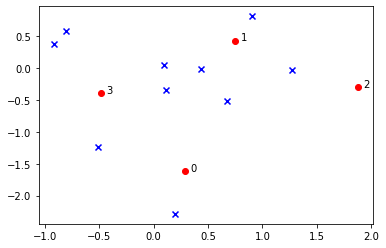

In [16]:
num_cands = 4

beta = 0.5
dim = 2

rankings,rcounts,voter_positions, cand_positions = create_prof_spatial_model2(10, 
                                                                              {c:c for c in range(num_cands)}, 
                                                                              [dim, beta])
prof = Profile(rankings, num_cands, rcounts=rcounts)

prof.display()

plt.scatter([v[0] for v in voter_positions], [v[1] for v in voter_positions], color='blue', marker='x')

plt.scatter([c[0] for c in cand_positions], [c[1] for c in cand_positions], color='red', marker='o')

for c_idx,c in enumerate(cand_positions):
    print(f"the utility of {c_idx} is {voter_utility(voter_positions[0], c, beta)}")

for c_idx,c in enumerate(cand_positions):
    plt.text(c[0]+0.05, c[1], c_idx)
plt.show()

+---+---+---+---+---+
| 1 | 3 | 1 | 4 | 1 |
+---+---+---+---+---+
| 1 | 2 | 0 | 2 | 0 |
| 3 | 1 | 2 | 0 | 3 |
| 2 | 0 | 1 | 1 | 2 |
| 0 | 3 | 3 | 3 | 1 |
+---+---+---+---+---+
the utility of 0 is -2.5677402717633777
the utility of 1 is -0.6786376429028804
the utility of 2 is -1.8056133601070092
the utility of 3 is -0.736847125052638


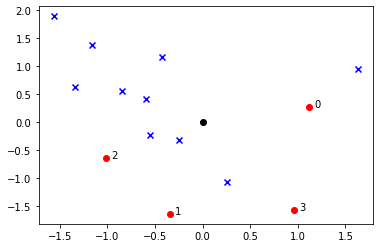

In [17]:
num_cands = 4
beta = 1.0
dim = 2


rankings,rcounts,voter_positions, cand_positions = create_prof_spatial_model2(10, 
                                                                              {c:c for c in range(num_cands)}, 
                                                                              [dim, beta])


prof = Profile(rankings, num_cands, rcounts=rcounts)

prof.display()


plt.scatter([v[0] for v in voter_positions], [v[1] for v in voter_positions], color='blue', marker='x')

plt.scatter([c[0] for c in cand_positions], [c[1] for c in cand_positions], color='red', marker='o')

plt.scatter([0], [0], color='black', marker='o')

for c_idx,c in enumerate(cand_positions):
    print(f"the utility of {c_idx} is {voter_utility(voter_positions[0], c, beta)}")

    
for c_idx,c in enumerate(cand_positions):
    plt.text(c[0]+0.05, c[1], c_idx)
plt.show()

In [18]:
num_voters = 10
num_cands = 4

e_model = "1d_interval"
#1d_interval
#1d_interval_bis"
#1d_gaussian
#1d_gaussian_bis
#1d_one_sided_triangle
#1d_full_triangle
#1d_two_party 

from mapel.voting import elections

rankings = elections.generate_elections_1d_simple(election_model = e_model, 
                                                  num_voters=num_voters, 
                                                  num_candidates = num_cands)

prof = Profile([tuple(r) for r in rankings], num_cands)
prof.display()


ModuleNotFoundError: No module named 'cplex'

In [19]:
num_voters = 10
num_cands = 4

e_model = "2d_disc"

#2d_disc
#2d_range_disc
#2d_range_overlapping
#2d_square 
#2d_sphere
#2d_gaussian
#2d_range_gaussian 
#2d_range_fourgau 

        
rankings = elections.generate_elections_2d_simple(election_model = e_model, 
                                                  num_voters=num_voters, 
                                                  num_candidates = num_cands)

prof = Profile([tuple(r) for r in rankings], num_cands)
prof.display()


NameError: name 'elections' is not defined

In [20]:
num_voters = 10
num_cands = 4


e_model = "40d_ball"

# 3d_sphere
# 3d_cube
# 3d_ball
# 4d_sphere
# 4d_cube
# 4d_ball
# 5d_sphere
# 5d_cube
# 5d_ball
# 10d_cube
# 15d_cube
# 20d_cube
# 40d_cube
# 40d_ball
   
rankings = elections.generate_elections_nd_simple(election_model = e_model, 
                                                  num_voters=num_voters, 
                                                  num_candidates = num_cands)

prof = Profile([tuple(r) for r in rankings], num_cands)
prof.display()


NameError: name 'elections' is not defined

## Mapping Elections



S. Szufa, P. Piotr Faliszewski, P. Skowron, A. Skinko,  and N. Talmon, [Drawing a Map of Elections in the Space of Statistical Cultures](http://www.ifaamas.org/Proceedings/aamas2020/pdfs/p1341.pdf), AAMAS 2020, Auckland, New Zealand, 


In [21]:
import mapel
import math
mapel.hello()

print()

#mapel.compute_highest_borda("testbed_100_100") 


ModuleNotFoundError: No module named 'cplex'

In [22]:
mapel.print_2d("testbed_100_100")

NameError: name 'mapel' is not defined

In [23]:
mapel.print_2d("testbed_100_100", mask=True)

NameError: name 'mapel' is not defined

In [24]:
import os
from mapel.voting import objects as obj

def get_highest_borda_score(election):
    scores = [0 for _ in range(election.num_candidates)]
    for vote in election.votes:
        print(vote)
        for i in range(len(vote)):
            scores[vote[i]] += election.num_candidates - i - 1
    return max(scores)


def is_condorect_winner(election):

    for i in range(election.num_candidates):

        condocret_winner = True
        for j in range(election.num_candidates):

            diff = 0
            for k in range(election.num_voters):

                if election.potes[k][i] <= election.potes[k][j]:
                    diff += 1

            if diff < math.ceil((election.num_voters+1)/2.):
                condocret_winner = False
                break

        if condocret_winner:
            return True

    return False


def compute_highest_borda(experiment_id):

    model = obj.Model(experiment_id)
    for i in range(model.num_elections)[0:10]:
        election_id = 'core_' + str(i)
        election = obj.Election(experiment_id, election_id)
        score = get_highest_borda_score(election)
        print(i, score)

        file_name = 'borda_score.txt'
        path = os.path.join(os.getcwd(), 'experiments', experiment_id, 'controllers', 'advanced', file_name)
        with open(path, 'a') as txtfile:
            txtfile.write(str(score) + "\n")

def compute_condorcet_winner(experiment_id):

    model = obj.Model(experiment_id)
    file_name = 'condorcet_score.txt'
    path = os.path.join(os.getcwd(), 'experiments', experiment_id, 'controllers', 'advanced', file_name)
    os.remove(path)
    for i in range(model.num_elections):
        election_id = 'core_' + str(i)
        election = obj.Election(experiment_id, election_id)
        score = float(int(is_condorect_winner(election)))
        print(i, score)

        file_name = 'condorcet_score.txt'
        path = os.path.join(os.getcwd(), 'experiments', experiment_id, 'controllers', 'advanced', file_name)
        with open(path, 'a') as txtfile:
            txtfile.write(str(score) + "\n")

compute_condorcet_winner('testbed_100_100')

0 0.0
1 1.0
2 1.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 1.0
17 0.0
18 0.0
19 0.0


20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0


32 0.0
33 1.0
34 0.0
35 0.0
36 0.0


37 0.0
38 1.0
39 0.0
40 1.0
41 1.0
42 1.0
43 1.0


44 0.0
45 1.0
46 0.0
47 1.0
48 1.0


49 0.0
50 1.0
51 0.0
52 1.0
53 0.0
54 1.0


55 0.0
56 0.0
57 1.0
58 1.0
59 0.0
60 1.0
61 1.0


62 0.0
63 0.0
64 0.0
65 1.0
66 1.0
67 1.0
68 1.0
69 1.0
70 1.0
71 1.0
72 1.0


73 1.0
74 0.0
75 0.0
76 1.0
77 0.0
78 0.0
79 1.0
80 1.0


81 1.0
82 1.0
83 1.0
84 1.0
85 1.0
86 1.0
87 1.0
88 1.0


89 1.0
90 1.0
91 1.0
92 1.0
93 1.0
94 1.0
95 1.0
96 1.0
97 1.0
98 1.0
99 1.0
100 1.0


101 1.0
102 0.0
103 1.0
104 1.0
105 1.0
106 0.0
107 0.0
108 1.0
109 1.0
110 0.0


111 1.0
112 1.0
113 1.0
114 1.0
115 1.0
116 1.0
117 1.0
118 1.0
119 1.0
120 1.0
121 1.0
122 1.0
123 1.0


124 1.0
125 1.0
126 1.0
127 1.0
128 1.0
129 1.0
130 1.0
131 1.0
132 1.0
133 1.0
134 1.0
135 1.0
136 0.0
137 1.0


138 1.0
139 1.0
140 1.0
141 1.0
142 1.0
143 1.0
144 1.0
145 1.0
146 1.0
147 1.0
148 1.0
149 1.0
150 1.0
151 1.0
152 1.0


153 0.0
154 1.0
155 1.0
156 1.0
157 1.0
158 1.0
159 0.0
160 1.0
161 1.0
162 1.0
163 1.0
164 1.0
165 1.0
166 1.0


167 1.0
168 1.0
169 0.0
170 1.0
171 1.0
172 1.0
173 1.0
174 0.0
175 1.0
176 0.0
177 1.0
178 1.0
179 1.0
180 1.0
181 1.0
182 1.0


183 1.0
184 1.0
185 1.0
186 1.0
187 1.0
188 1.0
189 0.0
190 1.0
191 1.0
192 0.0
193 1.0
194 1.0
195 1.0
196 1.0
197 1.0
198 0.0


199 1.0
200 1.0
201 1.0
202 1.0
203 0.0
204 1.0
205 1.0
206 0.0
207 1.0
208 1.0
209 1.0
210 0.0
211 0.0


212 1.0
213 0.0
214 0.0
215 0.0
216 0.0


217 1.0
218 0.0
219 0.0
220 0.0
221 0.0
222 0.0
223 0.0


224 1.0
225 0.0
226 1.0
227 0.0
228 0.0
229 0.0


230 0.0
231 0.0
232 0.0
233 0.0
234 0.0
235 0.0
236 0.0
237 0.0
238 0.0


239 0.0
240 0.0
241 0.0
242 0.0
243 0.0
244 0.0
245 0.0
246 0.0
247 0.0
248 0.0


249 0.0
250 0.0
251 0.0
252 0.0
253 0.0
254 0.0
255 0.0
256 0.0
257 0.0
258 0.0
259 0.0
260 0.0
261 0.0
262 0.0
263 0.0
264 0.0


265 0.0
266 0.0
267 0.0
268 0.0
269 0.0
270 0.0
271 1.0
272 0.0
273 0.0
274 0.0
275 0.0
276 0.0
277 0.0
278 0.0
279 0.0
280 0.0


281 0.0
282 0.0
283 0.0
284 0.0
285 0.0
286 0.0
287 0.0
288 0.0
289 0.0
290 0.0
291 0.0
292 0.0
293 0.0
294 0.0
295 0.0
296 0.0
297 0.0


298 0.0
299 0.0
300 0.0
301 0.0
302 0.0
303 0.0
304 0.0
305 0.0
306 0.0
307 1.0


308 0.0
309 0.0
310 0.0
311 0.0
312 0.0
313 0.0
314 0.0
315 0.0
316 1.0
317 0.0
318 0.0


319 0.0
320 1.0
321 0.0
322 0.0
323 0.0
324 0.0
325 0.0
326 0.0


327 0.0
328 0.0
329 0.0
330 1.0
331 1.0
332 1.0
333 0.0
334 1.0
335 1.0
336 1.0


337 1.0
338 1.0
339 1.0
340 1.0
341 1.0
342 1.0
343 0.0
344 0.0
345 0.0
346 1.0


347 1.0
348 1.0
349 1.0
350 1.0
351 1.0
352 1.0
353 1.0
354 1.0
355 1.0
356 1.0


357 1.0
358 1.0
359 1.0
360 1.0
361 0.0
362 0.0


363 0.0
364 0.0
365 0.0
366 0.0
367 1.0


368 0.0
369 1.0
370 0.0
371 0.0
372 0.0
373 1.0


374 0.0
375 0.0
376 0.0
377 0.0


378 1.0
379 0.0
380 1.0
381 0.0
382 1.0


383 0.0
384 1.0
385 0.0
386 0.0
387 1.0


388 0.0
389 0.0
390 1.0
391 1.0
392 0.0


393 1.0
394 1.0
395 1.0
396 1.0
397 1.0
398 1.0
399 1.0


400 1.0
401 1.0
402 0.0
403 1.0
404 1.0


405 1.0
406 0.0
407 1.0
408 1.0
409 1.0
410 1.0


411 1.0
412 1.0
413 1.0
414 1.0
415 0.0
416 1.0
417 1.0


418 1.0
419 1.0
420 0.0
421 1.0
422 1.0
423 1.0
424 1.0
425 0.0
426 0.0
427 1.0
428 0.0
429 0.0
430 0.0
431 0.0
432 0.0
433 0.0
434 0.0
435 1.0
436 1.0
437 1.0


438 0.0
439 1.0
440 0.0
441 0.0
442 0.0
443 0.0
444 0.0
445 1.0
446 0.0
447 1.0
448 0.0
449 1.0
450 1.0
451 0.0
452 0.0
453 1.0
454 0.0
455 0.0
456 0.0
457 1.0
458 0.0
459 0.0


460 0.0
461 0.0
462 1.0
463 0.0
464 1.0
465 0.0
466 0.0
467 0.0
468 0.0
469 0.0
470 1.0
471 0.0
472 0.0
473 0.0
474 0.0
475 0.0
476 0.0
477 0.0
478 0.0
479 0.0
480 0.0


481 0.0
482 0.0
483 0.0
484 0.0
485 0.0
486 0.0
487 0.0
488 0.0
489 0.0
490 0.0
491 0.0
492 0.0
493 0.0
494 0.0
495 0.0
496 0.0
497 0.0
498 0.0
499 1.0
500 1.0
501 1.0
502 0.0
503 0.0


504 0.0
505 0.0
506 0.0
507 0.0
508 0.0
509 0.0
510 0.0
511 0.0
512 0.0
513 0.0
514 0.0
515 0.0
516 0.0
517 1.0
518 0.0
519 0.0
520 1.0
521 0.0
522 0.0
523 1.0
524 0.0
525 0.0


526 0.0
527 0.0
528 1.0
529 0.0
530 0.0
531 0.0
532 0.0
533 0.0
534 0.0
535 0.0
536 1.0
537 1.0
538 0.0
539 0.0
540 0.0
541 0.0
542 0.0
543 0.0
544 1.0
545 0.0
546 0.0
547 0.0


548 0.0
549 0.0
550 0.0
551 0.0
552 0.0
553 0.0
554 0.0
555 0.0
556 0.0
557 0.0
558 0.0
559 0.0
560 0.0
561 0.0
562 0.0
563 0.0
564 0.0
565 0.0
566 0.0
567 0.0
568 0.0
569 0.0


570 0.0
571 0.0
572 0.0
573 0.0
574 0.0
575 0.0
576 0.0
577 0.0
578 0.0
579 0.0
580 0.0
581 0.0
582 0.0
583 0.0
584 0.0
585 1.0
586 0.0
587 0.0
588 0.0
589 0.0
590 0.0
591 0.0


592 0.0
593 0.0
594 0.0
595 0.0
596 0.0
597 0.0
598 0.0
599 0.0
600 0.0
601 0.0
602 0.0
603 0.0
604 0.0
605 0.0
606 0.0
607 0.0
608 0.0
609 0.0
610 0.0
611 0.0


612 0.0
613 0.0
614 0.0
615 0.0
616 0.0
617 0.0
618 0.0
619 0.0
620 0.0
621 0.0
622 1.0
623 0.0
624 0.0
625 0.0
626 0.0
627 0.0
628 1.0
629 0.0
630 0.0
631 1.0
632 0.0
633 0.0
634 0.0
635 0.0
636 0.0
637 0.0
638 1.0
639 0.0
640 0.0


641 0.0
642 1.0
643 1.0
644 0.0
645 0.0
646 1.0
647 1.0
648 1.0
649 1.0
650 1.0
651 1.0
652 0.0
653 0.0
654 0.0
655 0.0
656 0.0
657 0.0
658 1.0
659 0.0
660 1.0
661 1.0
662 1.0
663 1.0
664 1.0
665 1.0
666 1.0
667 1.0
668 1.0


669 1.0
670 1.0
671 1.0
672 0.0
673 1.0
674 1.0
675 1.0
676 1.0
677 1.0
678 1.0
679 1.0
680 1.0
681 1.0
682 1.0
683 1.0
684 1.0
685 1.0
686 1.0
687 1.0


688 1.0
689 1.0
690 1.0
691 1.0
692 1.0
693 1.0
694 1.0
695 1.0
696 1.0
697 1.0
698 1.0
699 1.0
700 1.0
701 1.0
702 1.0
703 1.0
704 1.0
705 1.0
706 1.0
707 1.0
708 1.0
709 1.0
710 1.0
711 1.0
712 1.0
713 1.0
714 1.0
715 1.0
716 1.0
717 1.0
718 1.0
719 1.0


720 1.0
721 1.0
722 1.0
723 1.0
724 1.0
725 1.0
726 1.0
727 1.0
728 1.0
729 1.0
730 1.0
731 1.0
732 1.0
733 1.0
734 1.0
735 1.0
736 1.0
737 1.0
738 1.0
739 1.0
740 1.0
741 1.0
742 1.0
743 1.0
744 1.0
745 1.0
746 1.0
747 1.0
748 1.0
749 1.0
750 1.0
751 1.0
752 1.0


753 1.0
754 1.0
755 1.0
756 1.0
757 1.0
758 1.0
759 1.0
760 1.0
761 1.0
762 1.0
763 1.0
764 1.0
765 1.0
766 1.0
767 1.0
768 1.0
769 1.0
770 1.0
771 1.0
772 1.0
773 1.0
774 1.0
775 1.0
776 1.0
777 1.0
778 1.0
779 1.0
780 1.0
781 1.0
782 1.0
783 1.0
784 1.0


785 1.0
786 1.0
787 1.0
788 1.0
789 1.0
790 1.0
791 1.0
792 1.0
793 1.0
794 1.0
795 1.0
796 1.0
797 1.0
798 1.0
799 1.0


In [25]:
mapel.print_2d("testbed_100_100", mask=True)

NameError: name 'mapel' is not defined

In [26]:
file_name = 'condorcet_score'
mapel.print_2d('testbed_100_100', values=file_name)


NameError: name 'mapel' is not defined

In [27]:
vms = [borda, hare, coombs, plurality_with_runoff, minimax]

def compute_diff_winners(experiment_id):

    file_name = 'diffvms_score.txt'
    path = os.path.join(os.getcwd(), 'experiments', experiment_id, 'controllers', 'advanced', file_name)
    os.remove(path)
    model = obj.Model(experiment_id)
    for i in range(model.num_elections):
        election_id = 'core_' + str(i)
        election = obj.Election(experiment_id, election_id)
        #print(election.votes)
        prof = Profile([tuple(r) for r in election.votes], election.num_candidates)
        num_diff = 0
        for vm in vms: 
            if plurality(prof) != vm(prof): 
                num_diff += 1
        score = float(num_diff) 
        print(i, score)

        file_name = 'diffvms_score.txt'
        path = os.path.join(os.getcwd(), 'experiments', experiment_id, 'controllers', 'advanced', file_name)
        with open(path, 'a') as txtfile:
            txtfile.write(str(score) + "\n")

compute_diff_winners('testbed_100_100')



0 5.0
1 5.0


2 5.0
3 4.0


4 3.0
5 5.0


6 3.0
7 5.0


8 5.0
9 4.0
10 4.0


11 5.0
12 5.0


13 5.0
14 5.0
15 5.0


16 5.0
17 5.0


18 5.0
19 5.0


20 5.0
21 5.0


22 5.0
23 5.0


24 5.0
25 5.0


26 5.0
27 4.0


28 5.0
29 5.0


30 5.0


31 5.0


32 4.0


33 5.0


34 5.0


35 5.0


36 5.0


37 5.0


38 5.0


39 5.0


40 5.0


41 5.0


42 5.0


43 2.0


44 5.0


45 5.0


46 5.0


47 5.0


48 4.0


49 5.0


50 5.0


51 5.0


52 5.0


53 4.0


54 5.0


55 5.0


56 5.0


57 5.0


58 5.0


59 5.0


60 5.0


61 4.0


62 5.0


63 5.0


64 5.0


65 3.0


66 3.0


67 5.0


68 5.0


69 5.0


70 5.0


71 4.0


72 4.0


73 5.0


74 5.0


75 5.0


76 5.0


77 5.0


78 5.0


79 4.0


80 5.0


81 5.0


82 5.0


83 5.0


84 5.0


85 4.0


86 5.0


87 5.0


88 5.0


89 5.0


90 5.0


91 5.0


92 4.0


93 5.0


94 5.0


95 5.0


96 5.0


97 5.0


98 4.0


99 4.0


100 5.0


101 4.0


102 5.0


103 3.0


104 5.0


105 4.0


106 4.0


107 5.0


108 5.0


109 5.0


110 5.0


111 5.0


112 5.0


113 5.0


114 5.0


115 3.0


116 3.0


117 5.0


118 5.0


119 4.0


120 3.0
121 5.0


122 5.0
123 4.0


124 4.0
125 5.0


126 4.0
127 5.0


128 5.0


129 5.0


130 5.0


131 5.0
132 5.0


133 4.0
134 5.0


135 5.0
136 5.0


137 4.0


138 5.0


139 5.0


140 5.0


141 4.0
142 5.0


143 5.0
144 5.0


145 5.0


146 5.0


147 4.0


148 5.0


149 5.0
150 0.0


151 5.0
152 3.0


153 5.0
154 5.0


155 5.0
156 5.0


157 5.0
158 5.0


159 4.0
160 5.0


161 5.0
162 5.0


163 5.0
164 4.0


165 5.0
166 1.0


167 5.0
168 5.0


169 4.0
170 5.0


171 5.0
172 4.0


173 5.0
174 4.0


175 5.0
176 5.0


177 4.0
178 0.0


179 5.0
180 5.0


181 5.0
182 5.0


183 5.0
184 4.0


185 4.0
186 5.0


187 5.0
188 5.0


189 5.0
190 4.0


191 5.0
192 5.0


193 5.0
194 5.0


195 5.0
196 0.0


197 0.0


198 4.0
199 5.0


200 5.0
201 5.0


202 4.0
203 5.0


204 0.0
205 5.0


206 5.0
207 5.0


208 5.0
209 5.0


210 4.0


211 5.0


212 5.0


213 5.0


214 5.0


215 4.0


216 4.0


217 5.0


218 4.0


219 5.0


220 5.0


221 5.0


222 4.0


223 5.0


224 2.0


225 4.0


226 1.0


227 5.0


228 5.0


229 4.0


230 3.0


231 5.0


232 5.0


233 3.0


234 5.0


235 5.0


236 2.0


237 1.0


238 5.0


239 4.0


240 5.0


241 4.0


242 5.0


243 3.0


244 5.0


245 5.0


246 5.0


247 5.0


248 5.0


249 5.0


250 5.0


251 5.0


252 4.0


253 5.0


254 5.0


255 2.0


256 4.0


257 5.0


258 5.0


259 3.0


260 5.0


261 5.0


262 4.0


263 4.0


264 4.0


265 5.0


266 5.0


267 4.0


268 5.0


269 5.0
270 4.0


271 4.0
272 5.0


273 4.0
274 5.0


275 5.0
276 5.0


277 5.0
278 3.0


279 5.0
280 5.0


281 5.0
282 3.0


283 5.0
284 5.0


285 5.0
286 5.0


287 4.0
288 5.0


289 5.0
290 4.0


291 5.0
292 4.0


293 5.0
294 5.0


295 5.0
296 5.0


297 5.0
298 5.0


299 5.0


300 5.0


301 5.0


302 5.0


303 5.0


304 5.0


305 5.0


306 4.0


307 5.0


308 5.0


309 5.0


310 5.0


311 3.0


312 5.0


313 5.0


314 5.0


315 5.0


316 4.0


317 5.0


318 5.0


319 4.0


320 5.0


321 4.0


322 5.0


323 4.0


324 5.0


325 5.0


326 5.0


327 3.0


328 5.0


329 5.0


330 5.0


331 4.0


332 3.0


333 5.0


334 5.0


335 4.0


336 5.0


337 5.0


338 5.0


339 5.0


340 5.0


341 4.0


342 5.0


343 5.0


344 5.0


345 5.0


346 4.0


347 5.0


348 3.0


349 5.0


350 5.0


351 5.0


352 5.0


353 5.0


354 5.0


355 5.0


356 5.0


357 4.0


358 5.0
359 5.0


360 3.0


361 5.0


362 5.0


363 4.0


364 5.0


365 5.0


366 5.0


367 5.0


368 5.0


369 5.0


370 5.0


371 5.0


372 5.0


373 5.0


374 4.0


375 4.0


376 3.0


377 5.0


378 1.0


379 5.0


380 4.0


381 5.0


382 3.0


383 5.0


384 5.0


385 5.0


386 5.0


387 5.0


388 5.0


389 4.0


390 1.0


391 1.0


392 5.0


393 5.0


394 4.0


395 5.0


396 3.0


397 5.0


398 4.0


399 0.0


400 5.0


401 5.0


402 3.0


403 5.0


404 3.0


405 1.0


406 3.0


407 5.0


408 4.0


409 5.0


410 3.0


411 2.0


412 0.0


413 4.0


414 4.0


415 4.0


416 2.0


417 5.0


418 5.0


419 3.0


420 1.0
421 1.0
422 0.0
423 1.0
424 0.0


425 4.0


426 1.0
427 1.0


428 1.0


429 1.0


430 2.0


431 1.0


432 2.0


433 5.0


434 4.0
435 0.0
436 0.0
437 0.0


438 3.0
439 1.0
440 2.0


441 2.0


442 1.0


443 5.0


444 1.0


445 4.0


446 1.0


447 0.0


448 4.0


449 1.0


450 1.0


451 3.0


452 0.0
453 0.0


454 4.0


455 2.0


456 3.0


457 0.0


458 5.0
459 5.0


460 2.0


461 2.0


462 1.0


463 2.0


464 3.0


465 1.0
466 5.0


467 3.0


468 5.0


469 2.0
470 1.0


471 2.0


472 1.0


473 5.0


474 2.0


475 4.0


476 3.0


477 1.0


478 1.0


479 4.0


480 3.0


481 2.0


482 4.0


483 4.0


484 5.0


485 4.0


486 4.0


487 4.0


488 2.0


489 4.0


490 2.0
491 3.0


492 4.0


493 1.0


494 4.0


495 4.0


496 5.0


497 5.0


498 3.0


499 5.0


500 5.0
501 1.0


502 3.0


503 4.0


504 4.0


505 4.0
506 4.0


507 3.0


508 1.0


509 3.0


510 3.0
511 4.0


512 5.0
513 3.0


514 5.0


515 3.0
516 5.0


517 4.0
518 5.0


519 3.0
520 0.0


521 4.0


522 5.0


523 4.0


524 5.0
525 5.0


526 5.0


527 5.0


528 1.0
529 4.0


530 0.0


531 3.0


532 4.0


533 5.0


534 4.0
535 4.0


536 4.0


537 1.0


538 5.0


539 3.0


540 5.0


541 3.0
542 5.0


543 4.0
544 5.0


545 3.0


546 5.0
547 5.0


548 5.0
549 4.0


550 1.0
551 5.0


552 5.0
553 5.0


554 3.0
555 4.0


556 5.0
557 5.0


558 4.0


559 4.0


560 4.0
561 4.0


562 5.0
563 5.0


564 5.0


565 4.0


566 4.0


567 5.0
568 1.0


569 5.0
570 5.0


571 5.0
572 4.0


573 3.0
574 4.0


575 4.0
576 5.0


577 5.0
578 3.0


579 4.0
580 5.0


581 5.0
582 5.0


583 3.0
584 4.0


585 5.0
586 5.0


587 5.0
588 5.0


589 4.0


590 5.0
591 4.0


592 5.0
593 4.0


594 4.0
595 4.0


596 5.0
597 5.0


598 5.0
599 5.0


600 5.0
601 5.0


602 5.0
603 5.0


604 5.0
605 5.0


606 5.0
607 5.0


608 4.0
609 5.0


610 5.0
611 5.0


612 4.0
613 5.0


614 5.0
615 5.0


616 5.0
617 5.0


618 5.0
619 4.0


620 4.0
621 3.0


622 0.0
623 5.0


624 5.0
625 5.0


626 4.0
627 5.0


628 5.0
629 4.0


630 5.0
631 5.0


632 5.0
633 5.0


634 3.0
635 5.0


636 3.0
637 5.0


638 4.0
639 4.0


640 5.0
641 3.0


642 4.0
643 0.0


644 4.0
645 4.0


646 5.0
647 5.0


648 5.0
649 0.0


650 4.0
651 5.0


652 5.0
653 5.0


654 4.0
655 5.0


656 5.0
657 5.0


658 5.0
659 4.0


660 0.0


661 0.0


662 0.0


663 0.0


664 0.0


665 0.0


666 0.0


667 0.0


668 1.0


669 5.0


670 0.0


671 0.0


672 5.0


673 0.0


674 0.0


675 0.0


676 0.0


677 0.0


678 0.0


679 0.0


680 0.0


681 0.0


682 0.0


683 0.0
684 0.0


685 0.0


686 0.0


687 0.0


688 0.0
689 0.0


690 0.0
691 0.0
692 0.0


693 0.0


694 0.0


695 0.0


696 0.0


697 0.0


698 0.0


699 0.0
700 0.0
701 0.0
702 0.0
703 0.0


704 0.0
705 0.0
706 0.0
707 0.0
708 0.0


709 0.0
710 0.0
711 0.0
712 0.0
713 0.0


714 0.0
715 0.0
716 0.0
717 0.0
718 0.0


719 0.0
720 0.0
721 0.0
722 0.0
723 0.0


724 0.0
725 0.0
726 0.0
727 0.0
728 0.0


729 0.0
730 0.0
731 0.0
732 0.0
733 0.0


734 0.0
735 0.0
736 0.0
737 0.0
738 0.0


739 0.0
740 0.0
741 0.0
742 0.0
743 0.0


744 0.0
745 0.0
746 0.0
747 0.0
748 0.0


749 0.0
750 0.0
751 0.0
752 0.0
753 0.0


754 0.0
755 0.0
756 0.0
757 0.0
758 0.0


759 0.0
760 0.0
761 0.0
762 0.0
763 0.0


764 0.0
765 0.0
766 0.0
767 0.0
768 0.0


769 0.0
770 0.0
771 0.0
772 0.0
773 0.0


774 0.0
775 0.0
776 0.0
777 0.0
778 0.0


779 0.0
780 0.0
781 0.0
782 0.0
783 0.0


784 0.0
785 0.0
786 0.0
787 0.0
788 0.0


789 0.0
790 0.0
791 0.0
792 0.0
793 0.0


794 0.0
795 0.0
796 0.0
797 0.0
798 0.0


799 0.0


In [28]:
file_name = 'diffvms_score'
mapel.print_2d('testbed_100_100', values=file_name)


NameError: name 'mapel' is not defined

In [29]:

vm = plurality 
def compute_condorcet_eff(experiment_id):

    model = obj.Model(experiment_id)
    file_name = 'condorceteff_score.txt'
    path = os.path.join(os.getcwd(), 'experiments', experiment_id, 'controllers', 'advanced', file_name)
    os.remove(path)

    for i in range(model.num_elections):
        election_id = 'core_' + str(i)
        election = obj.Election(experiment_id, election_id)
        #print(election.votes)
        prof = Profile([tuple(r) for r in election.votes], election.num_candidates)
        cw = prof.condorcet_winner()
        _score = cw is None or [cw] == vm(prof)
        score = float(_score) 
        print(i, score)

        path = os.path.join(os.getcwd(), 'experiments', experiment_id, 'controllers', 'advanced', file_name)
        with open(path, 'a') as txtfile:
            txtfile.write(str(score) + "\n")

compute_condorcet_eff('testbed_100_100')


0 1.0
1 0.0
2 0.0
3 1.0
4 1.0
5 1.0


6 1.0
7 1.0
8 1.0
9 1.0
10 1.0
11 1.0


12 1.0
13 1.0
14 1.0
15 1.0
16 0.0
17 1.0


18 1.0
19 1.0
20 1.0
21 1.0
22 1.0
23 1.0


24 1.0
25 1.0
26 1.0
27 1.0
28 1.0
29 1.0


30 1.0
31 1.0
32 1.0
33 0.0
34 1.0
35 1.0
36 1.0


37 1.0
38 0.0
39 1.0
40 0.0
41 0.0
42 0.0
43 1.0


44 1.0
45 0.0
46 1.0
47 0.0
48 0.0
49 1.0
50 0.0


51 1.0
52 0.0
53 1.0
54 0.0
55 1.0
56 1.0
57 0.0


58 0.0
59 1.0
60 0.0
61 0.0
62 1.0
63 1.0
64 1.0


65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0


72 0.0
73 0.0
74 1.0
75 1.0
76 0.0
77 1.0
78 1.0


79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0


86 0.0
87 0.0
88 0.0
89 0.0
90 0.0
91 0.0
92 0.0


93 0.0
94 0.0
95 0.0
96 0.0
97 0.0
98 0.0
99 0.0


100 0.0
101 0.0
102 1.0
103 0.0
104 0.0
105 0.0
106 1.0


107 1.0
108 0.0
109 0.0
110 1.0
111 0.0
112 0.0
113 0.0


114 0.0
115 0.0
116 0.0
117 0.0
118 0.0
119 0.0
120 0.0


121 0.0
122 0.0
123 0.0
124 0.0
125 0.0
126 0.0


127 0.0
128 0.0
129 0.0
130 0.0
131 0.0
132 0.0
133 0.0


134 0.0
135 0.0
136 1.0
137 0.0
138 0.0
139 0.0


140 0.0
141 0.0
142 0.0
143 0.0
144 0.0
145 0.0


146 0.0
147 0.0
148 0.0
149 0.0
150 1.0
151 0.0
152 0.0


153 1.0
154 0.0
155 0.0
156 0.0
157 0.0
158 0.0


159 1.0
160 0.0
161 0.0
162 0.0
163 0.0
164 0.0


165 0.0
166 1.0
167 0.0
168 0.0
169 1.0
170 0.0


171 0.0
172 0.0
173 0.0
174 1.0
175 0.0
176 1.0


177 0.0
178 1.0
179 0.0
180 0.0
181 0.0
182 0.0


183 0.0
184 0.0
185 0.0
186 0.0
187 0.0
188 0.0


189 1.0
190 0.0
191 0.0
192 1.0
193 0.0
194 0.0


195 0.0
196 1.0
197 1.0
198 1.0
199 0.0
200 0.0


201 0.0
202 0.0
203 1.0
204 1.0
205 0.0
206 1.0


207 0.0
208 0.0
209 0.0
210 1.0
211 1.0
212 0.0
213 1.0


214 1.0
215 1.0
216 1.0
217 0.0
218 1.0
219 1.0
220 1.0


221 1.0
222 1.0
223 1.0
224 1.0
225 1.0
226 1.0
227 1.0


228 1.0
229 1.0
230 1.0
231 1.0
232 1.0
233 1.0
234 1.0


235 1.0
236 1.0
237 1.0
238 1.0
239 1.0
240 1.0
241 1.0


242 1.0
243 1.0
244 1.0
245 1.0
246 1.0
247 1.0


248 1.0
249 1.0
250 1.0
251 1.0
252 1.0
253 1.0


254 1.0
255 1.0
256 1.0
257 1.0
258 1.0
259 1.0


260 1.0
261 1.0
262 1.0
263 1.0
264 1.0
265 1.0


266 1.0
267 1.0
268 1.0
269 1.0
270 1.0
271 0.0


272 1.0
273 1.0
274 1.0
275 1.0
276 1.0
277 1.0


278 1.0
279 1.0
280 1.0
281 1.0
282 1.0
283 1.0


284 1.0
285 1.0
286 1.0
287 1.0
288 1.0
289 1.0


290 1.0
291 1.0
292 1.0
293 1.0
294 1.0
295 1.0


296 1.0
297 1.0
298 1.0
299 1.0
300 1.0
301 1.0


302 1.0
303 1.0
304 1.0
305 1.0
306 1.0
307 0.0
308 1.0


309 1.0
310 1.0
311 1.0
312 1.0
313 1.0
314 1.0
315 1.0


316 0.0
317 1.0
318 1.0
319 1.0
320 0.0
321 1.0
322 1.0


323 1.0
324 1.0
325 1.0
326 1.0
327 1.0
328 1.0
329 1.0


330 0.0
331 0.0
332 0.0
333 1.0
334 0.0
335 0.0
336 0.0


337 0.0
338 0.0
339 0.0
340 0.0
341 0.0
342 0.0
343 1.0


344 1.0
345 1.0
346 0.0
347 0.0
348 0.0
349 0.0
350 0.0


351 0.0
352 0.0
353 0.0
354 0.0
355 0.0
356 0.0
357 0.0


358 0.0
359 0.0
360 1.0
361 1.0
362 1.0
363 1.0
364 1.0


365 1.0
366 1.0
367 0.0
368 1.0
369 0.0
370 1.0
371 1.0


372 1.0
373 0.0
374 1.0
375 1.0
376 1.0
377 1.0


378 1.0
379 1.0
380 0.0
381 1.0
382 0.0
383 1.0
384 0.0


385 1.0
386 1.0
387 0.0
388 1.0
389 1.0
390 1.0
391 1.0


392 1.0
393 0.0
394 0.0
395 0.0
396 0.0
397 0.0
398 0.0


399 1.0
400 0.0
401 0.0
402 1.0
403 0.0
404 0.0
405 1.0


406 1.0
407 0.0
408 0.0
409 0.0
410 0.0
411 1.0
412 1.0


413 0.0
414 0.0
415 1.0
416 1.0
417 0.0
418 0.0
419 0.0


420 1.0
421 1.0
422 1.0
423 1.0
424 1.0
425 1.0
426 1.0


427 1.0
428 1.0
429 1.0
430 1.0
431 1.0
432 1.0
433 1.0


434 1.0
435 1.0
436 1.0
437 1.0
438 1.0
439 1.0
440 1.0


441 1.0
442 1.0
443 1.0
444 1.0
445 0.0
446 1.0
447 1.0


448 1.0
449 1.0
450 1.0
451 1.0
452 1.0
453 1.0
454 1.0


455 1.0
456 1.0
457 1.0
458 1.0
459 1.0
460 1.0
461 1.0


462 1.0
463 1.0
464 0.0
465 1.0
466 1.0
467 1.0
468 1.0


469 1.0
470 1.0
471 1.0
472 1.0
473 1.0
474 1.0
475 1.0


476 1.0
477 1.0
478 1.0
479 1.0
480 1.0
481 1.0


482 1.0
483 1.0
484 1.0
485 1.0
486 1.0
487 1.0


488 1.0
489 1.0
490 1.0
491 1.0
492 1.0
493 1.0


494 1.0
495 1.0
496 1.0
497 1.0
498 1.0
499 0.0


500 0.0
501 1.0
502 1.0
503 1.0
504 1.0
505 1.0


506 1.0
507 1.0
508 1.0
509 1.0
510 1.0
511 1.0


512 1.0
513 1.0
514 1.0
515 1.0
516 1.0
517 0.0


518 1.0
519 1.0
520 1.0
521 1.0
522 1.0
523 0.0


524 1.0
525 1.0
526 1.0
527 1.0
528 1.0
529 1.0


530 1.0
531 1.0
532 1.0
533 1.0
534 1.0
535 1.0


536 0.0
537 1.0
538 1.0
539 1.0
540 1.0
541 1.0


542 1.0
543 1.0
544 0.0
545 1.0
546 1.0
547 1.0


548 1.0
549 1.0
550 1.0
551 1.0
552 1.0
553 1.0


554 1.0
555 1.0
556 1.0
557 1.0
558 1.0
559 1.0


560 1.0
561 1.0
562 1.0
563 1.0
564 1.0
565 1.0


566 1.0
567 1.0
568 1.0
569 1.0
570 1.0
571 1.0


572 1.0
573 1.0
574 1.0
575 1.0
576 1.0
577 1.0


578 1.0
579 1.0
580 1.0
581 1.0
582 1.0
583 1.0


584 1.0
585 0.0
586 1.0
587 1.0
588 1.0
589 1.0


590 1.0
591 1.0
592 1.0
593 1.0
594 1.0
595 1.0


596 1.0
597 1.0
598 1.0
599 1.0
600 1.0
601 1.0


602 1.0
603 1.0
604 1.0
605 1.0
606 1.0


607 1.0
608 1.0
609 1.0
610 1.0
611 1.0


612 1.0
613 1.0
614 1.0
615 1.0
616 1.0


617 1.0
618 1.0
619 1.0
620 1.0
621 1.0
622 1.0


623 1.0
624 1.0
625 1.0
626 1.0
627 1.0
628 0.0


629 1.0
630 1.0
631 0.0
632 1.0
633 1.0


634 1.0
635 1.0
636 1.0
637 1.0
638 0.0
639 1.0


640 1.0
641 1.0
642 0.0
643 1.0
644 1.0
645 1.0


646 0.0
647 0.0
648 0.0
649 1.0
650 0.0
651 0.0


652 1.0
653 1.0
654 1.0
655 1.0
656 1.0
657 1.0


658 0.0
659 1.0
660 1.0
661 1.0
662 1.0
663 1.0
664 1.0


665 1.0
666 1.0
667 1.0
668 1.0
669 0.0
670 1.0
671 1.0


672 1.0
673 1.0
674 1.0
675 1.0
676 1.0
677 1.0
678 1.0


679 1.0
680 1.0
681 1.0
682 1.0
683 1.0
684 1.0
685 1.0


686 1.0
687 1.0
688 1.0
689 1.0
690 1.0
691 1.0
692 1.0


693 1.0
694 1.0
695 1.0
696 1.0
697 1.0
698 1.0
699 1.0


700 1.0
701 1.0
702 1.0
703 1.0
704 1.0
705 1.0
706 1.0


707 1.0
708 1.0
709 1.0
710 1.0
711 1.0
712 1.0
713 1.0


714 1.0
715 1.0
716 1.0
717 1.0
718 1.0
719 1.0
720 1.0


721 1.0
722 1.0
723 1.0
724 1.0
725 1.0
726 1.0
727 1.0


728 1.0
729 1.0
730 1.0
731 1.0
732 1.0
733 1.0
734 1.0


735 1.0
736 1.0
737 1.0
738 1.0
739 1.0
740 1.0
741 1.0


742 1.0
743 1.0
744 1.0
745 1.0
746 1.0
747 1.0


748 1.0
749 1.0
750 1.0
751 1.0
752 1.0
753 1.0


754 1.0
755 1.0
756 1.0
757 1.0
758 1.0
759 1.0
760 1.0


761 1.0
762 1.0
763 1.0
764 1.0
765 1.0
766 1.0
767 1.0


768 1.0
769 1.0
770 1.0
771 1.0
772 1.0
773 1.0
774 1.0


775 1.0
776 1.0
777 1.0
778 1.0
779 1.0
780 1.0
781 1.0
782 1.0


783 1.0
784 1.0
785 1.0
786 1.0
787 1.0
788 1.0
789 1.0
790 1.0


791 1.0
792 1.0
793 1.0
794 1.0
795 1.0
796 1.0
797 1.0
798 1.0


799 1.0


In [30]:
file_name = 'condorceteff_score'
mapel.print_2d('testbed_100_100', values=file_name, normalizing_func = lambda x: x)


NameError: name 'mapel' is not defined

In [31]:
vm = hare 
def compute_size_ws(experiment_id):

    model = obj.Model(experiment_id)
    file_name = 'size_winning_set_score.txt'
    path = os.path.join(os.getcwd(), 'experiments', experiment_id, 'controllers', 'advanced', file_name)
    os.remove(path)

    for i in range(model.num_elections):
        election_id = 'core_' + str(i)
        election = obj.Election(experiment_id, election_id)
        #print(election.votes)
        prof = Profile([tuple(r) for r in election.votes], election.num_candidates)
        cw = prof.condorcet_winner()
        score = float(len(vm(prof))) 
        print(i, score)

        path = os.path.join(os.getcwd(), 'experiments', experiment_id, 'controllers', 'advanced', file_name)
        with open(path, 'a') as txtfile:
            txtfile.write(str(score) + "\n")

compute_size_ws('testbed_100_100')


0 1.0
1 1.0
2 1.0
3 1.0


4 2.0
5 1.0
6 1.0
7 1.0


8 1.0
9 1.0
10 1.0
11 1.0


12 1.0
13 1.0
14 1.0
15 1.0


16 1.0
17 1.0
18 1.0
19 1.0


20 1.0
21 1.0
22 1.0
23 1.0


24 2.0
25 1.0
26 1.0
27 1.0


28 1.0
29 1.0
30 1.0
31 1.0
32 1.0


33 1.0
34 1.0
35 1.0
36 1.0
37 1.0


38 1.0
39 1.0
40 1.0
41 1.0
42 1.0


43 1.0
44 1.0
45 1.0
46 1.0
47 1.0


48 1.0
49 1.0
50 1.0
51 1.0
52 1.0


53 2.0
54 1.0
55 1.0
56 1.0
57 1.0


58 1.0
59 1.0
60 1.0
61 1.0
62 1.0


63 1.0
64 1.0
65 1.0
66 1.0
67 1.0


68 1.0
69 1.0
70 1.0
71 1.0
72 1.0


73 1.0
74 1.0
75 1.0
76 1.0


77 1.0
78 2.0
79 1.0
80 1.0


81 1.0
82 1.0
83 1.0
84 1.0
85 1.0


86 1.0
87 1.0
88 1.0
89 1.0
90 1.0


91 1.0
92 1.0
93 1.0
94 1.0


95 1.0
96 1.0
97 1.0
98 1.0


99 1.0
100 1.0
101 1.0
102 1.0


103 1.0
104 1.0
105 1.0
106 1.0


107 1.0
108 1.0
109 1.0
110 1.0


111 1.0
112 1.0
113 1.0
114 1.0
115 1.0


116 1.0
117 1.0
118 1.0
119 1.0


120 1.0
121 1.0
122 1.0
123 1.0


124 1.0
125 1.0
126 1.0
127 2.0


128 1.0
129 1.0
130 1.0
131 1.0


132 1.0
133 1.0
134 1.0
135 1.0


136 1.0
137 1.0
138 1.0
139 1.0


140 1.0
141 1.0
142 1.0
143 1.0


144 1.0
145 1.0
146 1.0
147 1.0


148 1.0
149 1.0
150 1.0
151 1.0


152 1.0
153 1.0
154 1.0
155 1.0


156 1.0
157 1.0
158 1.0
159 1.0


160 1.0
161 1.0
162 1.0
163 1.0


164 1.0
165 1.0
166 1.0
167 1.0


168 1.0
169 1.0
170 1.0
171 1.0


172 1.0
173 2.0
174 2.0
175 1.0


176 1.0
177 1.0
178 1.0
179 1.0


180 1.0
181 1.0
182 1.0
183 1.0


184 1.0
185 1.0
186 1.0
187 1.0


188 2.0
189 1.0
190 1.0
191 1.0


192 1.0
193 1.0
194 1.0
195 1.0
196 1.0


197 1.0
198 1.0
199 1.0
200 1.0


201 1.0
202 1.0
203 1.0
204 1.0


205 1.0
206 1.0
207 1.0
208 1.0


209 1.0
210 1.0
211 1.0
212 1.0


213 1.0
214 1.0
215 1.0
216 1.0
217 1.0


218 1.0
219 1.0
220 1.0
221 1.0
222 1.0


223 1.0
224 1.0
225 1.0
226 1.0
227 1.0


228 1.0
229 1.0
230 1.0
231 1.0
232 1.0


233 1.0
234 1.0
235 1.0
236 1.0
237 1.0


238 1.0
239 1.0
240 1.0
241 1.0


242 1.0
243 1.0
244 2.0
245 1.0


246 1.0
247 1.0
248 1.0
249 1.0


250 1.0
251 1.0
252 1.0
253 1.0


254 1.0
255 1.0
256 2.0
257 1.0


258 1.0
259 1.0
260 1.0
261 1.0


262 1.0
263 1.0
264 1.0
265 1.0


266 1.0
267 1.0
268 1.0
269 1.0


270 1.0
271 1.0
272 1.0
273 1.0


274 1.0
275 1.0
276 1.0
277 1.0


278 1.0
279 1.0
280 1.0
281 1.0


282 1.0
283 1.0
284 1.0
285 1.0


286 1.0
287 1.0
288 1.0
289 1.0


290 1.0
291 1.0
292 1.0
293 1.0


294 1.0
295 1.0
296 1.0
297 1.0


298 1.0
299 1.0
300 1.0
301 1.0


302 1.0
303 1.0
304 1.0
305 1.0


306 1.0
307 1.0
308 1.0
309 1.0
310 1.0


311 1.0
312 1.0
313 1.0
314 1.0
315 1.0


316 1.0
317 1.0
318 1.0
319 1.0


320 1.0
321 1.0
322 1.0
323 1.0


324 1.0
325 2.0
326 1.0
327 1.0


328 1.0
329 1.0
330 1.0
331 1.0
332 1.0


333 1.0
334 1.0
335 1.0
336 1.0
337 1.0
338 1.0


339 1.0
340 1.0
341 1.0
342 1.0
343 1.0
344 1.0


345 1.0
346 1.0
347 1.0
348 1.0
349 1.0
350 1.0


351 1.0
352 1.0
353 1.0
354 2.0
355 1.0
356 1.0


357 1.0
358 1.0
359 1.0
360 1.0
361 1.0


362 1.0
363 1.0
364 1.0
365 1.0
366 1.0


367 1.0
368 1.0
369 1.0
370 1.0
371 1.0


372 1.0
373 1.0
374 2.0
375 1.0
376 1.0


377 1.0
378 1.0
379 1.0
380 1.0
381 1.0


382 1.0
383 1.0
384 1.0
385 1.0
386 1.0


387 1.0
388 2.0
389 1.0
390 1.0
391 1.0


392 1.0
393 1.0
394 1.0
395 1.0
396 1.0


397 1.0
398 1.0
399 1.0
400 1.0
401 1.0


402 1.0
403 1.0
404 1.0
405 1.0
406 1.0


407 1.0
408 1.0
409 1.0
410 1.0
411 1.0


412 1.0
413 1.0
414 1.0
415 1.0
416 2.0


417 1.0
418 1.0
419 1.0
420 1.0
421 1.0
422 1.0


423 1.0
424 1.0
425 1.0
426 1.0
427 1.0
428 1.0


429 1.0
430 1.0
431 1.0
432 1.0
433 1.0


434 2.0
435 1.0
436 1.0
437 1.0
438 1.0
439 1.0


440 1.0
441 1.0
442 1.0
443 2.0
444 1.0


445 1.0
446 1.0
447 1.0
448 1.0
449 1.0
450 1.0


451 1.0
452 1.0
453 1.0
454 1.0
455 1.0


456 1.0
457 1.0
458 1.0
459 1.0
460 1.0


461 1.0
462 1.0
463 1.0
464 1.0
465 1.0


466 1.0
467 1.0
468 1.0
469 1.0
470 1.0


471 1.0
472 1.0
473 1.0
474 1.0
475 1.0


476 1.0
477 1.0
478 1.0
479 1.0
480 1.0


481 1.0
482 1.0
483 1.0
484 1.0
485 1.0


486 1.0
487 1.0
488 1.0
489 1.0
490 1.0


491 1.0
492 1.0
493 1.0
494 1.0
495 1.0


496 1.0
497 1.0
498 1.0
499 1.0
500 1.0


501 1.0
502 1.0
503 1.0
504 1.0
505 1.0


506 1.0
507 1.0
508 1.0
509 1.0
510 1.0


511 1.0
512 1.0
513 1.0
514 1.0
515 1.0


516 1.0
517 2.0
518 1.0
519 1.0
520 1.0


521 1.0
522 1.0
523 1.0
524 1.0
525 1.0


526 2.0
527 1.0
528 1.0
529 1.0
530 1.0


531 1.0
532 1.0
533 1.0
534 1.0
535 1.0


536 1.0
537 1.0
538 1.0
539 1.0


540 1.0
541 1.0
542 1.0
543 1.0


544 1.0
545 1.0
546 1.0
547 1.0


548 1.0
549 2.0
550 1.0
551 1.0


552 1.0
553 1.0
554 1.0
555 1.0


556 1.0
557 1.0
558 1.0
559 1.0


560 1.0
561 1.0
562 1.0
563 1.0


564 1.0
565 2.0
566 1.0
567 1.0


568 1.0
569 1.0
570 1.0
571 1.0


572 1.0
573 1.0
574 2.0
575 1.0


576 1.0
577 2.0
578 1.0
579 1.0


580 1.0
581 1.0
582 1.0
583 1.0


584 1.0
585 1.0
586 1.0
587 1.0


588 4.0
589 1.0
590 1.0
591 1.0


592 1.0
593 1.0
594 1.0
595 1.0


596 1.0
597 1.0
598 1.0
599 1.0


600 1.0
601 1.0
602 1.0
603 1.0


604 1.0
605 1.0
606 1.0
607 1.0


608 1.0
609 1.0
610 1.0
611 1.0


612 1.0
613 1.0
614 1.0
615 1.0


616 1.0
617 1.0
618 1.0
619 1.0


620 2.0
621 1.0
622 1.0
623 1.0


624 1.0
625 1.0
626 1.0
627 1.0


628 1.0
629 1.0
630 1.0
631 1.0


632 1.0
633 2.0
634 1.0
635 1.0


636 1.0
637 1.0
638 1.0
639 2.0


640 1.0
641 1.0
642 1.0
643 1.0
644 2.0


645 1.0
646 1.0
647 1.0
648 1.0
649 1.0


650 1.0
651 1.0
652 1.0
653 1.0


654 2.0
655 1.0
656 1.0
657 1.0
658 1.0


659 1.0
660 1.0
661 1.0
662 1.0
663 1.0
664 1.0


665 1.0
666 1.0
667 1.0
668 1.0
669 1.0
670 1.0


671 1.0
672 2.0
673 1.0
674 1.0
675 1.0
676 1.0


677 1.0
678 1.0
679 1.0
680 1.0
681 1.0
682 1.0


683 1.0
684 1.0
685 1.0
686 1.0
687 1.0
688 1.0


689 1.0
690 1.0
691 1.0
692 1.0
693 1.0
694 1.0
695 1.0


696 1.0
697 1.0
698 1.0
699 1.0
700 1.0
701 1.0
702 1.0


703 1.0
704 1.0
705 1.0
706 1.0
707 1.0
708 1.0
709 1.0


710 1.0
711 1.0
712 1.0
713 1.0
714 1.0
715 1.0
716 1.0


717 1.0
718 1.0
719 1.0
720 1.0
721 1.0
722 1.0
723 1.0


724 1.0
725 1.0
726 1.0
727 1.0
728 1.0
729 1.0
730 1.0


731 1.0
732 1.0
733 1.0
734 1.0
735 1.0
736 1.0
737 1.0


738 1.0
739 1.0
740 1.0
741 1.0
742 1.0
743 1.0
744 1.0


745 1.0
746 1.0
747 1.0
748 1.0
749 1.0
750 1.0
751 1.0


752 1.0
753 1.0
754 1.0
755 1.0
756 1.0
757 1.0
758 1.0


759 1.0
760 1.0
761 1.0
762 1.0
763 1.0
764 1.0
765 1.0


766 1.0
767 1.0
768 1.0
769 1.0
770 1.0
771 1.0
772 1.0


773 1.0
774 1.0
775 1.0
776 1.0
777 1.0
778 1.0
779 1.0


780 1.0
781 1.0
782 1.0
783 1.0
784 1.0
785 1.0
786 1.0


787 1.0
788 1.0
789 1.0
790 1.0
791 1.0
792 1.0
793 1.0


794 1.0
795 1.0
796 1.0
797 1.0
798 1.0
799 1.0


In [32]:
file_name = 'size_winning_set_score'
mapel.print_2d('testbed_100_100', values=file_name)


NameError: name 'mapel' is not defined

## Real Elections

In [33]:
import glob
election_data_directory = './election-data/'


In [34]:
# read the file containing election data and return a profile
def read_election_data(fname):
    with open(fname, 'r') as fp:
        line = fp.readline()
        num_cands = int(line)
        remaining_lines = fp.readlines()
        num_rankings = remaining_lines[num_cands]
        rankings_data = remaining_lines[num_cands + 1:]
        anon_prof = {}
        rankings = list()
        rcounts = list()
        for r in rankings_data:
            _ranking = r.split(',')
            num = int(_ranking[0])
            rankings.append(tuple([int(_.strip()) - 1 for _ in _ranking[1:num_cands+1]]))
            rcounts.append(num)
        
        return Profile(rankings,  num_cands, rcounts = rcounts)



prof = read_election_data(f"{election_data_directory}ED-00025-00000002.soc")

prof.display()

prof.condorcet_winner()

+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+
| 200 | 86 | 69 | 45 | 42 | 35 | 34 | 28 | 27 | 22 | 20 | 19 | 19 | 18 | 18 | 17 | 17 | 16 | 15 | 14 | 12 | 10 | 6 | 6 |
+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+
|  0  | 0  | 0  | 1  | 0  | 1  | 1  | 0  | 0  | 2  | 1  | 1  | 3  | 2  | 1  | 2  | 3  | 2  | 3  | 2  | 3  | 2  | 3 | 3 |
|  1  | 1  | 2  | 0  | 3  | 2  | 0  | 3  | 2  | 0  | 3  | 3  | 0  | 3  | 2  | 1  | 1  | 1  | 0  | 0  | 1  | 3  | 2 | 2 |
|  2  | 3  | 1  | 2  | 1  | 0  | 3  | 2  | 3  | 1  | 0  | 2  | 1  | 0  | 3  | 0  | 2  | 3  | 2  | 3  | 0  | 1  | 1 | 0 |
|  3  | 2  | 3  | 3  | 2  | 3  | 2  | 1  | 1  | 3  | 2  | 0  | 2  | 1  | 0  | 3  | 0  | 0  | 1  | 1  | 2  | 0  | 0 | 1 |
+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+


0

In [35]:
num_elections = 0
num_condorcet_winner = 0
num_cycle = 0
for fname in glob.glob(election_data_directory + "/*.soc"):
    num_elections += 1
    prof = read_election_data(fname)
    print(f"Election {num_elections}")
    print("\tNumber of candidates: ", prof.num_cands)
    print("\tNumber of voters: ", prof.num_voters)
    
    num_condorcet_winner += prof.condorcet_winner() is not None
    num_cycle += has_cycle(prof.margin_graph())
    
print(f"Out of {num_elections} elections:")
print(f"\t{round(num_condorcet_winner / num_elections, 4)*100}% have a Condorcet winner")
print(f"\t{round(num_cycle / num_elections, 4)*100}% have a cycle in the majority graph")

Election 1
	Number of candidates:  30
	Number of voters:  7
Election 2
	Number of candidates:  4
	Number of voters:  362
Election 3
	Number of candidates:  4
	Number of voters:  1256
Election 4
	Number of candidates:  4
	Number of voters:  369
Election 5
	Number of candidates:  32
	Number of voters:  4
Election 6
	Number of candidates:  60
	Number of voters:  4
Election 7
	Number of candidates:  131
	Number of voters:  4
Election 8
	Number of candidates:  3
	Number of voters:  405
Election 9
	Number of candidates:  3
	Number of voters:  779
Election 10
	Number of candidates:  3
	Number of voters:  1377
Election 11
	Number of candidates:  3
	Number of voters:  496
Election 12
	Number of candidates:  3
	Number of voters:  963
Election 13
	Number of candidates:  3
	Number of voters:  440
Election 14
	Number of candidates:  70
	Number of voters:  4
Election 15
	Number of candidates:  52
	Number of voters:  4
Election 16
	Number of candidates:  81
	Number of voters:  4
Election 17
	Number o

Election 25
	Number of candidates:  3
	Number of voters:  751
Election 26
	Number of candidates:  3
	Number of voters:  1117
Election 27
	Number of candidates:  3
	Number of voters:  490
Election 28
	Number of candidates:  3
	Number of voters:  363
Election 29
	Number of candidates:  3
	Number of voters:  982
Election 30
	Number of candidates:  44
	Number of voters:  4


Election 31
	Number of candidates:  100
	Number of voters:  4
Election 32
	Number of candidates:  4
	Number of voters:  518
Election 33
	Number of candidates:  4
	Number of voters:  411
Election 34
	Number of candidates:  20
	Number of voters:  9
Election 35
	Number of candidates:  4
	Number of voters:  494
Election 36
	Number of candidates:  4
	Number of voters:  422
Election 37
	Number of candidates:  40
	Number of voters:  4
Election 38
	Number of candidates:  21
	Number of voters:  4
Election 39
	Number of candidates:  3
	Number of voters:  695
Election 40
	Number of candidates:  3
	Number of voters:  397
Election 41
	Number of candidates:  3
	Number of voters:  417
Election 42
	Number of candidates:  3
	Number of voters:  382
Election 43
	Number of candidates:  3
	Number of voters:  1008
Election 44
	Number of candidates:  3
	Number of voters:  383
Election 45
	Number of candidates:  23
	Number of voters:  4
Election 46
	Number of candidates:  28
	Number of voters:  4
Election 47


Election 73
	Number of candidates:  142
	Number of voters:  4


Election 74
	Number of candidates:  103
	Number of voters:  5
Election 75
	Number of candidates:  4
	Number of voters:  391
Election 76
	Number of candidates:  3
	Number of voters:  1591
Election 77
	Number of candidates:  3
	Number of voters:  3705
Election 78
	Number of candidates:  3
	Number of voters:  1215
Election 79
	Number of candidates:  3
	Number of voters:  533
Election 80
	Number of candidates:  242
	Number of voters:  5


Election 81
	Number of candidates:  112
	Number of voters:  4
Election 82
	Number of candidates:  102
	Number of voters:  4
Election 83
	Number of candidates:  4
	Number of voters:  532
Election 84
	Number of candidates:  4
	Number of voters:  903
Election 85
	Number of candidates:  4
	Number of voters:  623
Election 86
	Number of candidates:  24
	Number of voters:  9
Election 87
	Number of candidates:  23
	Number of voters:  9
Election 88
	Number of candidates:  4
	Number of voters:  447
Election 89
	Number of candidates:  4
	Number of voters:  425
Election 90
	Number of candidates:  4
	Number of voters:  430
Election 91
	Number of candidates:  99
	Number of voters:  4
Election 92
	Number of candidates:  122
	Number of voters:  4
Election 93
	Number of candidates:  55
	Number of voters:  4
Election 94
	Number of candidates:  3
	Number of voters:  1022
Election 95
	Number of candidates:  3
	Number of voters:  664
Election 96
	Number of candidates:  3
	Number of voters:  375


Election 97
	Number of candidates:  3
	Number of voters:  423
Election 98
	Number of candidates:  3
	Number of voters:  379
Election 99
	Number of candidates:  240
	Number of voters:  5
Election 100
	Number of candidates:  68
	Number of voters:  4


Election 101
	Number of candidates:  96
	Number of voters:  4
Election 102
	Number of candidates:  115
	Number of voters:  4
Election 103
	Number of candidates:  6
	Number of voters:  15
Election 104
	Number of candidates:  4
	Number of voters:  485
Election 105
	Number of candidates:  4
	Number of voters:  420
Election 106
	Number of candidates:  4
	Number of voters:  350
Election 107
	Number of candidates:  23
	Number of voters:  9
Election 108
	Number of candidates:  19
	Number of voters:  9
Election 109
	Number of candidates:  4
	Number of voters:  355
Election 110
	Number of candidates:  4
	Number of voters:  512
Election 111
	Number of candidates:  4
	Number of voters:  473
Election 112
	Number of candidates:  115
	Number of voters:  4
Election 113
	Number of candidates:  67
	Number of voters:  4
Election 114
	Number of candidates:  87
	Number of voters:  4
Election 115
	Number of candidates:  3
	Number of voters:  833
Election 116
	Number of candidates:  3
	Number of voters:  13

Election 121
	Number of candidates:  115
	Number of voters:  4
Election 122
	Number of candidates:  64
	Number of voters:  4
Election 123
	Number of candidates:  91
	Number of voters:  4
Election 124
	Number of candidates:  4
	Number of voters:  384
Election 125
	Number of candidates:  4
	Number of voters:  883
Election 126
	Number of candidates:  4
	Number of voters:  443
Election 127
	Number of candidates:  18
	Number of voters:  9
Election 128
	Number of candidates:  18
	Number of voters:  7
Election 129
	Number of candidates:  23
	Number of voters:  9
Election 130
	Number of candidates:  4
	Number of voters:  732
Election 131
	Number of candidates:  23
	Number of voters:  9
Election 132
	Number of candidates:  4
	Number of voters:  358
Election 133
	Number of candidates:  4
	Number of voters:  408
Election 134
	Number of candidates:  153
	Number of voters:  4


Election 135
	Number of candidates:  82
	Number of voters:  4
Election 136
	Number of candidates:  3
	Number of voters:  1860
Election 137
	Number of candidates:  3
	Number of voters:  617
Election 138
	Number of candidates:  3
	Number of voters:  529
Election 139
	Number of candidates:  3
	Number of voters:  940
Election 140
	Number of candidates:  95
	Number of voters:  4
Election 141
	Number of candidates:  128
	Number of voters:  4
Election 142
	Number of candidates:  4
	Number of voters:  448
Election 143
	Number of candidates:  4
	Number of voters:  446
Election 144
	Number of candidates:  18
	Number of voters:  7
Election 145
	Number of candidates:  4
	Number of voters:  525
Election 146
	Number of candidates:  18
	Number of voters:  9
Election 147
	Number of candidates:  4
	Number of voters:  418
Election 148
	Number of candidates:  4
	Number of voters:  392
Election 149
	Number of candidates:  14
	Number of voters:  9
Election 150
	Number of candidates:  4
	Number of voters:  

Election 153
	Number of candidates:  240
	Number of voters:  5
Election 154
	Number of candidates:  3
	Number of voters:  542
Election 155
	Number of candidates:  3
	Number of voters:  501
Election 156
	Number of candidates:  3
	Number of voters:  467
Election 157
	Number of candidates:  3
	Number of voters:  360
Election 158
	Number of candidates:  4
	Number of voters:  795
Election 159
	Number of candidates:  242
	Number of voters:  4


Election 160
	Number of candidates:  127
	Number of voters:  4
Election 161
	Number of candidates:  4
	Number of voters:  803
Election 162
	Number of candidates:  4
	Number of voters:  391
Election 163
	Number of candidates:  20
	Number of voters:  9
Election 164
	Number of candidates:  4
	Number of voters:  731
Election 165
	Number of candidates:  4
	Number of voters:  657
Election 166
	Number of candidates:  4
	Number of voters:  440
Election 167
	Number of candidates:  4
	Number of voters:  382
Election 168
	Number of candidates:  11
	Number of voters:  30
Election 169
	Number of candidates:  23
	Number of voters:  9
Election 170
	Number of candidates:  4
	Number of voters:  352
Election 171
	Number of candidates:  4
	Number of voters:  547
Election 172
	Number of candidates:  4
	Number of voters:  797
Election 173
	Number of candidates:  4
	Number of voters:  405
Election 174
	Number of candidates:  106
	Number of voters:  4


Election 175
	Number of candidates:  240
	Number of voters:  4
Election 176
	Number of candidates:  69
	Number of voters:  4
Election 177
	Number of candidates:  4
	Number of voters:  800
Election 178
	Number of candidates:  3
	Number of voters:  1083
Election 179
	Number of candidates:  3
	Number of voters:  808
Election 180
	Number of candidates:  3
	Number of voters:  1045
Election 181
	Number of candidates:  3
	Number of voters:  595
Election 182
	Number of candidates:  3
	Number of voters:  716
Election 183
	Number of candidates:  3
	Number of voters:  732
Election 184
	Number of candidates:  4
	Number of voters:  794


Election 185
	Number of candidates:  163
	Number of voters:  4
Election 186
	Number of candidates:  102
	Number of voters:  4
Election 187
	Number of candidates:  4
	Number of voters:  583
Election 188
	Number of candidates:  4
	Number of voters:  436
Election 189
	Number of candidates:  4
	Number of voters:  378
Election 190
	Number of candidates:  20
	Number of voters:  9
Election 191
	Number of candidates:  4
	Number of voters:  1814
Election 192
	Number of candidates:  4
	Number of voters:  578
Election 193
	Number of candidates:  4
	Number of voters:  417
Election 194
	Number of candidates:  4
	Number of voters:  823
Election 195
	Number of candidates:  4
	Number of voters:  793
Election 196
	Number of candidates:  4
	Number of voters:  454
Election 197
	Number of candidates:  4
	Number of voters:  486
Election 198
	Number of candidates:  4
	Number of voters:  394
Election 199
	Number of candidates:  242
	Number of voters:  5


Election 200
	Number of candidates:  71
	Number of voters:  4
Election 201
	Number of candidates:  93
	Number of voters:  4
Election 202
	Number of candidates:  3
	Number of voters:  2769
Election 203
	Number of candidates:  3
	Number of voters:  474
Election 204
	Number of candidates:  3
	Number of voters:  407
Election 205
	Number of candidates:  3
	Number of voters:  2641
Election 206
	Number of candidates:  3
	Number of voters:  352
Election 207
	Number of candidates:  3
	Number of voters:  842
Election 208
	Number of candidates:  89
	Number of voters:  4
Election 209
	Number of candidates:  63
	Number of voters:  4
Election 210
	Number of candidates:  103
	Number of voters:  4
Election 211
	Number of candidates:  4
	Number of voters:  408
Election 212
	Number of candidates:  4
	Number of voters:  395
Election 213
	Number of candidates:  4
	Number of voters:  366
Election 214
	Number of candidates:  4
	Number of voters:  801
Election 215
	Number of candidates:  4
	Number of voters:

Election 225
	Number of candidates:  3
	Number of voters:  737
Election 226
	Number of candidates:  3
	Number of voters:  351
Election 227
	Number of candidates:  3
	Number of voters:  416
Election 228
	Number of candidates:  3
	Number of voters:  727
Election 229
	Number of candidates:  10
	Number of voters:  5000
Election 230
	Number of candidates:  4
	Number of voters:  794
Election 231
	Number of candidates:  103
	Number of voters:  5
Election 232
	Number of candidates:  100
	Number of voters:  4
Election 233
	Number of candidates:  4
	Number of voters:  400
Election 234
	Number of candidates:  4
	Number of voters:  380
Election 235
	Number of candidates:  4
	Number of voters:  795
Election 236
	Number of candidates:  4
	Number of voters:  412
Election 237
	Number of candidates:  4
	Number of voters:  535
Election 238
	Number of candidates:  24
	Number of voters:  9
Election 239
	Number of candidates:  4
	Number of voters:  357
Election 240
	Number of candidates:  4
	Number of vote

Election 258
	Number of candidates:  4
	Number of voters:  419
Election 259
	Number of candidates:  4
	Number of voters:  472
Election 260
	Number of candidates:  4
	Number of voters:  447
Election 261
	Number of candidates:  4
	Number of voters:  376
Election 262
	Number of candidates:  4
	Number of voters:  373
Election 263
	Number of candidates:  37
	Number of voters:  4
Election 264
	Number of candidates:  44
	Number of voters:  4
Election 265
	Number of candidates:  3
	Number of voters:  713
Election 266
	Number of candidates:  3
	Number of voters:  996
Election 267
	Number of candidates:  3
	Number of voters:  998
Election 268
	Number of candidates:  3
	Number of voters:  10347
Election 269
	Number of candidates:  3
	Number of voters:  369
Election 270
	Number of candidates:  3
	Number of voters:  14081
Election 271
	Number of candidates:  3
	Number of voters:  1688
Election 272
	Number of candidates:  3
	Number of voters:  1074
Election 273
	Number of candidates:  56
	Number of 